## Meta -omic evaluation of proteases and proteolysis

11/09/2020<br>
Author: Robert Mills<br>
Environment: Qiime2-2019.7<br>
<br>
<i>This notebook contains code for reproducing several figures related to evaluating proteases and proteolysis in meta omic data from the manuscript, <b> "Meta–omics Reveals Microbiome Driven Proteolysis as a Contributing Factor to Severity of Ulcerative Colitis Disease Activity" </b>by Mills et al. <br><br>
Data sheets used here will be made available on Massive.ucsd.edu

In [1]:
#Import packages
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import scipy
from scipy import stats
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import fdrcorrection
from matplotlib_venn import venn2
import sys
from matplotlib_venn import venn3
from scipy.stats import linregress

In [2]:
#Makes figures with white background
sns.set_style("white")
#Allows visualization within the ipython notebook format
%matplotlib inline

In [3]:
#Optional for disabling warnings
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

#### User defined functions

In [4]:
def LinearRegressions(df,metadata,variable):
    """
    This function will perform linear regressions on all features in a dataframe. Each row is a feature and each column is a sample.The function appends appends new columns for the stats associated with the linear regression.
    A mask is in place to detect missing values, and remove them from the regression. The fraction of samples missing the feature is listed as an additional column.


    
    Parameters
    ----------
    df : pd.DataFrame
    metadata : pd.DataFrame
    variable: String

    Returns
    -------
    Dataframe with stats on linear regressions
    """
    
    samples = list(df.columns)
    meta2 = metadata[metadata.index.isin(samples)]

    #Remove non-numeric samples
    meta3 =	meta2[pd.to_numeric(meta2[variable], errors='coerce').notnull()]
    samples2 = list(meta3.index)
    df2 = df[samples2]

    df2.loc['%s'%(variable)] = meta3[variable].astype('float')

    #Order patients by the variable & add linregress stats
    Order = list(meta3[variable].sort_values().index)
    linregstats =['slope','intercept','rvalue','pvalue','stderr']
    for i in linregstats:
        Order.append(i)

    #Reindex to sort the data columns
    df2 = df2.reindex(columns = Order)

    #Remove the features that have no values (or are a missing value)
    df2 = df2.dropna(axis=0,how='all')
    df2 = df2.loc[df2.index.dropna()]

    #Apply linear regressions to the variable
    slope = []
    intercept = []
    rvalue = []
    pvalue = []
    stderr = []
    sparsity = []

    for i in df2.index:
        a = df2.loc[i]
        b = df2.loc[variable]
        mask = ~np.isnan(df2.loc[i]) & ~np.isnan(df2.loc[variable])
        linres = linregress(a[mask],b[mask])
        #linres = linregress(a[samples],b[samples])
        slope.append(linres.slope)
        intercept.append(linres.intercept)
        rvalue.append(linres.rvalue)
        pvalue.append(linres.pvalue)
        stderr.append(linres.stderr)
        sparsity.append((np.isnan(df2[samples2].loc[i])).astype(int).sum()/len(a[samples2]))
    df2['slope'] = slope
    df2['intercept'] = intercept
    df2['rvalue'] = rvalue
    df2['pvalue'] = pvalue
    df2['stderr'] = stderr
    df2['sparsity_prcnt'] = sparsity

    global df_out
    df_out = df2  
    return 'Linear regressions performed on %s. New dataframe stored as "df_out"'%(variable)

In [5]:
def PSM_quality_filters(df, labels_df):
    """
    This function takes the raw PSM output file from proteome discoverer and applies several
    quality control filtering; 1) A redundancy filter which removes redundant PSMs that should
    not be included in the protein quantitation, 2) An average signal to noise filter removing
    PSMs with an average signal to noise ratio <10, 3) A spectral interference filter removing
    PSMs with more than 25% interference, 4) Removal of rejected and low confidence PSMs.
    
    As part of the average signal to noise filter, we add a pseudocount of 1 to channels
    missing any quantitation.
    
    parameters
    ----------
    df: pd.DataFrame
    labels_df: pd.DataFrame
    
    returns
    -------
    input dataframe with low quality PSMs removed
    
    """
    channels = ['126', '127N', '127C', '128N',
       '128C', '129N', '129C', '130N', '130C', '131']
    
    #Remove low confidence PSMs, report number removed
    df2 = df[df['Confidence'] == 'High']
    removed = (len(df) - len(df2))
    print("Number of low confidence PSMs removed: %s" % removed)
    
    #Remove Rejected PSMs, report number removed
    df3 = df2[df2['PSM Ambiguity'] != 'Rejected']
    removed = (len(df2) - len(df3))
    print("Number of ambiguous 'rejected' PSMs removed: %s" % removed)
    
    #Remove the PSMs with high interference
    df4 = df3[df3['Isolation Interference [%]'] < 25]
    removed = (len(df3) - len(df4))
    print("Number of PSMs with high interference removed: %s" % removed)
    
    #Remove duplicate & redundant PSMs
    #here we collect the index of each PSM that should not be included
    Keep_list = list(df4[(df4["Peptide Quan Usage"] != "DoNotUse") & (df4["Quan Info"] != "Redundant")].index)
    
    #Subset out the keep list PSMs
    df5 = df4.loc[df4.index.isin(Keep_list)]
    removed = (len(df4) - len(df5))
    print("Number of redundant PSMs removed: %s" % removed)
    
    #Remove PSMs with low avg signal
    #Replace NaN with 1
    df5 = df5.replace(np.nan, 1)
    #Replace 0 with 1
    df5 = df5.replace(0, 1)
    #Detect the na valued channels so we don't count them in the average
    
    #Find and save the channels to use per experiment in a dictionary
    global dataframe_collection
    dataframe_collection = {}
    Experiments = list(labels_df['Experiment'])
    Experiment_labels={}
    Low_avg_removed = 0
    for i in Experiments:
        NA_Channels = []
        exp_channels = ['126', '127N', '127C', '128N', '128C', '129N', '129C', '130N','130C','131']
        for j in channels:
            if pd.isnull(labels_df.loc[i][j]) == True:
                NA_Channels.append(j)
        for j in NA_Channels:
            exp_channels.remove(j)
        df_sep = df5[df5['Experiment'] == i]
        df_sep[exp_channels] = df_sep[exp_channels].astype('float64')
        df_sep['Avg_Sig2Noise'] = df_sep[exp_channels].mean(axis=1)
        df_sep2 = df_sep[df_sep['Avg_Sig2Noise'] > 10]
        
       
        
        Low_avg_removed = (len(df_sep) - len(df_sep2)) + Low_avg_removed
        #Save to collection
        dataframe_collection["%s" % i] = df_sep2
        #dataframe_collection["%s_LowSignalFiltered" % i] = df_sep3
        #dataframe_collection["%s_RejectPSMs" % i] = PSM_Reject
    
    removed = (len(df5) - Low_avg_removed)
    print("Number of PSMs with low average signal removed: %s" % Low_avg_removed)
    
    #Report the percent of PSMs removed in quality control
    removed_percent = (len(df) - removed)/len(df)
    print("Percent of PSMs removed during quality filtering: %s" % removed_percent)
    
    return print("Dataframes per experiment with low quality PSMs removed saved under name: dataframe_collection")

In [6]:
def Sum_PSMs_per_Experiment(df_collection, labels_df, experiment_column):
    """
    This function takes a dictionary of  dataframes containing PSMs seperated per experiment,
    a column name which contains the name of the experiment each PSMs was found in. 

    The function outputs the dataframes containing summed signal to noise ratios per protein 
    for each experiment. Each dataframe is placed in a new collection of dataframes.
    
    The function also creates a list of the average signal found per protein for later use.
    
    parameters
    ----------
    df_collection: pd.DataFrame
    labels_df: pd.DataFrame
    experiment_column: string
    
    returns
    -------
    A collection of dataframes
    
    """
    channels = ['126', '127N', '127C', '128N',
       '128C', '129N', '129C', '130N', '130C', '131']
    
    
    
    Experiment_list = list(labels_df['Experiment'])
    
    #Create dataframes per experiment & sum PSMs per protein
    global dataframe_collection2
    global current_df
    dataframe_collection2 = {}
    Avg_vals = []
    for i in Experiment_list:
        #Subset df
        current_df = df_collection[i]

        #Change index
        current_df.index = current_df['Protein']
        NA_Channels = []
        for j in channels:
            if pd.isnull(labels_df.loc[i][j]) == True:
                NA_Channels.append(j)
        exp_channels = ['126', '127N', '127C', '128N',
       '128C', '129N', '129C', '130N', '130C', '131']
        for j in NA_Channels:
            exp_channels.remove(j)        
        #subset out only the used channels
        current_df = current_df[exp_channels].astype('float64')
        #Sum by protein
        current_df = current_df[exp_channels].astype('float64').groupby([current_df.index]).agg(['sum'])
        #Find the average signal per protein
        current_df['Protein_Avg']=current_df[exp_channels].astype('float64').mean(axis=1)
        #Add bridge channel values to one list
        Avg_vals = list(current_df['Protein_Avg']) + Avg_vals
        #Print the number of proteins quantified in each experiment
        print("Number of proteins quantified in Experiment %s: %s" % (i, len(current_df)))
        #Save to collection
        dataframe_collection2["%s" % i] = current_df
    global Avg_median
    Avg_median = np.median(Avg_vals)
    return print('Collection of dataframes per experiments saved under name: dataframe_collection2; Median of protein averages saved under name: Avg_median')

In [7]:
def Two_Bridge_Normalization(df_collection,label_df,bridge_channels,bridge_median):
    """
    This function performs two normalization steps analagous to what was developed for 
    normalization of RNA seq data. The first step of normalization largely accounts 
    for differences in the number of peptides used to quantify each protein which would 
    drive all associations when comparing protein quant values between experiments where 
    a different number of PSMs was identified within the same protein. The second step helps
    remove some of the systematic errors that occur between samples
    
    The function takes a collection dataframes with summed protein quant values in separate 
    dataframes dependent on the experiment.
    
    Side note - don't have any sample names that are named 126 or 131 as they interfere with channel names.
    
    parameters
    ----------
    df_collection: pd.dict
    label_df: pd.DataFrame
    bridge_channels: list
    bridge_median: float
    
    returns
    -------
    A new dataframe with normalized values per protein.
    
    """
    channels = ['126', '127N', '127C', '128N',
       '128C', '129N', '129C', '130N', '130C', '131']
    
    #First Normalization step
    #Value/(protein val in bridge/Median of all bridge)
    
    global dataframe_collection3
    global current_df2
    global labels
    global Exp_labels
    global all_samples
    global Experiment_samples
    
    dataframe_collection3 = {}
    Experiment_list = list(label_df.index)
    for i in Experiment_list:
        #Subset out label metadata for current experiment
        Exp_labels = label_df[label_df.index == '%s' % i]
        
        #Make a list of channels containing samples in the current experiment
        NA_Channels = []
        for j in channels:
            if pd.isnull(label_df.loc[i][j]) == True:
                NA_Channels.append(j)
        exp_channels = ['126', '127N', '127C', '128N',
       '128C', '129N', '129C', '130N', '130C', '131']
        for j in NA_Channels:
            exp_channels.remove(j)        
        for j in bridge_channels:
        	exp_channels.remove(j)
        
        #Subset df
        current_df2 = df_collection['%s' % i]
        #Perform normalization into a new column labeled by actual sample name
        #First identify the average value for each protein and create a new column
        current_df2['bridge_mean'] = current_df2[bridge_channels].mean(axis=1)
        #Create a list of the names of samples in this experiment, to subset out only the channels containing names
        Experiment_samples = []
        for j in exp_channels:
            name = Exp_labels.loc['%s' % i][j]
            Experiment_samples.append(name)
            current_df2['%s' % name] = current_df2['%s' % j]['sum']/(current_df2['bridge_mean']/bridge_median)
        #Subset out the columns with names of samples
        current_df2 = current_df2[Experiment_samples]
        #Save to collection of dfs with columns containing sample names
        dataframe_collection3["%s" % i] = current_df2
    
    #Make another list of dataframes to merge with first experiment
    Exp1 = Experiment_list[0]
    Experiment_list_remove1 = Experiment_list
    Experiment_list_remove1.remove(Exp1)
    
    #Merge all dataframes by protein accession
    #Start with first experiment in separate df
    global combined_df
    combined_df = dataframe_collection3['%s' % Exp1]
    for i in Experiment_list_remove1:
        current_df3 = dataframe_collection3['%s' % i]
        combined_df = combined_df.merge(current_df3, left_index = True, right_index = True, how = 'outer')
    
    #Remove "Sums" fromt the multi index
    combined_df.columns = combined_df.columns.droplevel(1)
    
    #Create list of all samples
    all_samples = list(combined_df.columns)
    
    #Second Normalization step
    #Value/(Median Value in Sample/Median of all values)
    global Overall_Median
    Overall_Median = np.nanmedian(combined_df)
    for i in all_samples:
            combined_df['%s_adj2' % i] = combined_df[i]/(combined_df[i].median()/Overall_Median)
    #Remove "_adj2" characters
    global Normalized_df
    combined_df2 = combined_df.drop(columns=all_samples)
    combined_df2 = combined_df2.rename(columns = lambda x : str(x)[:-5])
    Normalized_df = combined_df2
    
    return print("Dataframe with normalized protein quants saved under name: Normalized_df")

In [8]:
def Sum_PSMs_per_Experiment_bridge(df_collection, labels_df, experiment_column, bridge_channels):
    """
    This function takes a dictionary of  dataframes containing PSMs seperated per experiment,
    a column name which contains the name of the experiment each PSMs was found in, 
    and a string listing the channel name which was used as a bridge channel. 
    The function outputs the dataframes containing summed signal to noise ratios per protein 
    for each experiment. Each dataframe is placed in a new collection of dataframes.
    
    parameters
    ----------
    df_collection: pd.DataFrame
    labels_df: pd.DataFrame
    experiment_column: string
    bridge_channels: list
    
    returns
    -------
    A collection of dataframes
    
    """
    channels = ['126', '127N', '127C', '128N',
       '128C', '129N', '129C', '130N', '130C', '131']
    
    
    
    Experiment_list = list(labels_df['Experiment'])
    
    #Create dataframes per experiment & sum PSMs per protein
    global dataframe_collection2
    global current_df
    global bridge_vals
    dataframe_collection2 = {}
    bridge_vals = []
    for i in Experiment_list:
        #Subset df
        current_df = df_collection[i]
        #Remove columns without a master protein
        current_df = current_df[current_df['Master Protein Accessions'] != 'nan']
        
        # Take the first Master Protein Accession from the protein groups as the representative
        # Protein. Place this protein name in a new column named "Master Protein"
        current_df['Master Protein Accessions'] = current_df['Master Protein Accessions'].astype('str')
        current_df['Master Protein'] = current_df['Master Protein Accessions'].apply(lambda x: x.split(';')[0])
        
        #Change index
        current_df.index = current_df['Master Protein']
        NA_Channels = []
        for j in channels:
            if pd.isnull(labels_df.loc[i][j]) == True:
                NA_Channels.append(j)
        exp_channels = ['126', '127N', '127C', '128N',
       '128C', '129N', '129C', '130N', '130C', '131']
        for j in NA_Channels:
            exp_channels.remove(j)        
        #subset out only the used channels
        current_df = current_df[exp_channels].astype('float64')
        #Sum by protein
        current_df = current_df[exp_channels].astype('float64').groupby([current_df.index]).agg(['sum'])
        #Add bridge channel values to one list
        for j in bridge_channels:
        	bridge_vals = list(current_df[j]['sum']) + bridge_vals	

        
        #Print the number of proteins quantified in each experiment
        print("Number of proteins quantified in Experiment %s: %s" % (i, len(current_df)))
        #Save to collection
        dataframe_collection2["%s" % i] = current_df
    global bridge_median
    bridge_median = np.median(bridge_vals)
    return print('Collection of dataframes per experiments saved under name: dataframe_collection2; Median of bridge channel saved under name: bridge_median')

In [9]:
def PlotByCategory(df,samples,Taxa_col,category,metadata,display_number,save_descrip,human="True",relative="True"):
    """
    This function allows you to average the abundance of a category by the levels within that category
    and plot stacked barplots of the relative abundance of the x most abundant groups within 
    each level
    
    Parameters
    ----------
    df_sig : pd.DataFrame
    Taxa_col : String
    Sparcity: np.float
    variable : Name of variable you're comparing ratios of
    display_number: np.integer
    human: String
    save_descrip : String

    Returns
    -------
    Dataframe with comparative ratios
    Dataframe with counts
    """
    #Split protein into multiple entries if "Taxa_col" contains ";" delimiter
    #Split up protein metadata for MG and sum it at for the desired variable
    s = df[Taxa_col].str.split(';').apply(pd.Series, 1).stack()
    s.index = s.index.droplevel(-1) # to line up with df's index
    s.name = 'Parsed_Category'
    GO = df.join(s)
    #Sum your dataframe by a category of interest 
    dfcategories = GO[samples].groupby(GO['Parsed_Category']).agg(['sum'])
    #Restructure the columns which become multilevel with the sum function                  
    dfcategories.columns = dfcategories.columns.droplevel(1)

    if human != "True":
        dfcategories.drop('Homo sapiens (Human)', inplace=True)
        
    
    #Save the postive and negative correlations per genera or eggNOG category
    counts = dfcategories
    
    #Find averages according to the levels in a category of interest
    
    #subset metadata to only list with patients of interest
    metadata.index = metadata.index.astype('str')
    meta2 = metadata.loc[samples]
    #Identify the levels within the metadata category
    levels_list = list(meta2[category].drop_duplicates().sort_values())
    #Add new column for patients regarding the level of the category of interest.
    counts.loc['%s' % category] = metadata['%s' % category]

    #Create a new column averaging by the levels within the category
    col_list = []
    for i in levels_list:
        a = counts[samples].T
        patients_in = []
        patients_in = list(a[a[category] == i].index.astype('str'))
        b = counts[patients_in].drop(category)
        b = b.astype('float')
        counts['%s_%s_Average' % (category, i)] = b[patients_in].mean(axis=1)
        col_list.append('%s_%s_Average' % (category, i))
    
    plot_df = counts[col_list]

    #Find the sum per variable
    plot_df['sum'] = plot_df.sum(axis=1)
    
    #Find the most abundantly correlated entry within the variable, group others
    top_list = list(plot_df.sort_values('sum', ascending=False)[0:display_number].index)
    Others = set(plot_df.index) - set(top_list)
    plot_df.loc['Others'] = plot_df.loc[Others].sum()
    top_list.append('Others')

    plot_df = plot_df.loc[top_list]

    #Convert to ratio for display
    if relative == "True":
        for i in col_list:
            plot_df[i] = plot_df[i]/plot_df[i].sum()

    plot_df = plot_df[col_list]
    
    #Remove index name
    del plot_df.index.name
    #Transpose
    plot_df = plot_df.transpose()
    #Get the dates in the correct order
    plot_df = plot_df.reindex(col_list)
    #Get variable into an order which depends on the abundance of each variable for easier interpretation
    plot_df = plot_df[plot_df.sum().sort_values(ascending = False).index]
    
    vals = np.linspace(0,1,display_number)
    np.random.shuffle(vals)
    my_cmap = plt.cm.colors.ListedColormap(plt.cm.Dark2(vals))
    
    plot1 = plot_df.plot(kind='bar', width = 0.8, stacked=True, colormap='tab20', figsize=(2,3),title='Relative frequency of %s within %s' % (Taxa_col,category))
    plot1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plot1
    plt.savefig('./Bacteroides_supernatant/Barplot_of_%s_by_%s_%s.pdf' %(Taxa_col,category,save_descrip),bbox_inches="tight")
    

In [10]:
ttests=[]
def ttest(df,ttdf1,ttdf2):
    from scipy.stats import ttest_ind
    ttdf1 = ttdf1.transpose()
    ttdf2 = ttdf2.transpose()
    ttests = ttest_ind(ttdf1,ttdf2,equal_var=False,nan_policy='omit')
    ttests = ttests.pvalue.transpose()
    df['ttest_pvalue']=ttests

In [11]:
def fold(df, sub1, sub2, sub1name, sub2name):
    df['%s Mean' % (sub1name)]=sub1.mean(axis=1,skipna=True)
    df['%s Mean' % (sub2name)]=sub2.mean(axis=1,skipna=True)
    df['Fold Change(%s/%s)' % (sub1name,sub2name)]=df['%s Mean' % (sub1name)]/df['%s Mean' % (sub2name)]
    print("Fold Change Column Name = 'Fold Change(%s/%s)'" %(sub1name,sub2name))
    

In [12]:
def piscore(df,sub1name,sub2name):
    df['Log2(Fold Change)'] = np.log2(df['Fold Change(%s/%s)'% (sub1name,sub2name)])
    df['-Log(P-value)'] = -np.log10(df['ttest_pvalue'])
    df['%s/%s pi score' % (sub1name,sub2name)] = df['-Log(P-value)']*df['Log2(Fold Change)']

In [13]:
def TwoCategoryMaster(dfmain,dfsub1,dfsub2,sub1name,sub2name):
    ttest(dfmain,dfsub1,dfsub2)
    fold(dfmain,dfsub1,dfsub2,sub1name,sub2name)
    piscore(dfmain,sub1name,sub2name)

##### Identifying the relationship between dipeptide abundance and IBD activity

In [159]:
#Metabolomic abundaces from first cohort of patients:
df = pd.read_csv('../UC_Severity/Metabolomics/StandardizedMzMIne2020Rerun/UC40_MB_Table_normalized.txt',
                sep='\t',index_col='#OTU ID')
meta = pd.read_csv('../UC_Severity/UC_MP_Emperor_Map.txt',sep ='\t', index_col = 'id')

#Metabolomics data from second cohort of patients:
df2 = pd.read_csv('./Metabolomics/MB_Standardized_Table_Normalized_Final.txt', sep = '\t', index_col = '#OTU ID')
meta2 = pd.read_csv('./Combined_Metadata_Allomics_MB_V2.txt',sep='\t',index_col='#SampleID')

#Metabolite annotations:
MB_ann1 = pd.read_csv('../UC_Severity/Metabolomics/StandardizedMzMIne2020Rerun/UC40_MB_Annotations.txt',sep='\t')
MB_ann2 = pd.read_csv('./Metabolomics/Qemistree_IDs.txt',sep='\t')


In [160]:
#Used this for averages but not for plotting individual points.
df.replace(0,np.nan,inplace=True)
df2.replace(0,np.nan,inplace=True)

In [161]:
#Annotate the metabolites:
df3 = df.merge(MB_ann1, left_index=True,right_on='rowID')
df4 = df2.merge(MB_ann2, left_index=True,right_on='rowid')

In [183]:
IBD200['Proteome_ID']

FIT288E3CAL_BD7_01_51897.mzXML              179
150675_333_BF11_01_52173.mzXML               48
FIT267E3CAL_GB7_01_52015.mzXML              203
FIT250E3CAL_BC8_01_52129.mzXML              158
FIT126E3CAL_GD8_01_52042.mzXML              102
000107225_BC2_01_52123.mzXML                114
FIT286E3CAL_GF2_01_52063.mzXML              134
FIT245E3CAL_BF3_01_52165.mzXML              152
FIT276E3CAL_BE10_01_52159.mzXML    not_analyzed
FIT207E3CAL_GG6_01_52081.mzXML               87
FIT256E3CAL_BE2_01_52150.mzXML     not_analyzed
FIT002CCAL_BE12_01_51914.mzXML              173
FIT013E3CAL_GF12_01_52074.mzXML               1
150675-339_BA4_01_52099.mzXML                37
FIT262E3CAL_BD5_01_52139.mzXML              193
FIT309E3CAL_BB4_01_52112.mzXML                3
FIT124E3CAL_GD10_01_52044.mzXML              52
FIT229E3CAL_GC10_01_52031.mzXML              13
FIT206E3CAL_GD4_01_52038.mzXML               25
FIT078E3CAL_BA8_01_51856.mzXML              181
FIT122E3CAL_BB6_01_52114.mzXML          

In [184]:
#Subset out dipeptides:
df3 = df3[df3['direct_parent']=='Dipeptides']
df4 = df4[df4['direct_parent']=='Dipeptides']

#Find the sum of the metabolite types:
avg_df4 = df4[df2.columns].groupby([df4['direct_parent']]).mean()
avg_df3 = df3[df.columns].groupby([df3['direct_parent']]).mean()
features = set(list(avg_df3.index) +list(avg_df4.index))
samples=list(df.columns)+list(df2.columns)

#Combine with the metadata and combine the datasets together:
IBD200 = avg_df4.T.merge(meta2,left_index=True,right_index=True)
#IBD200.index = IBD200['Proteome_ID']
UC40 = avg_df3.T.merge(meta,left_index=True,right_index=True)
UC40['Diagnosis'] = 'UC'
UC40['Experiment'] = 'Cohort 1'
IBD200['Experiment'] = 'Cohort 2'
amino_combine=pd.concat([UC40,IBD200])
amino_combine.reset_index(inplace=True)

#Perform a melt to transform into longform dataframe
interest_cols=['Diagnosis','Experiment','index','Activity_Level','Relative_Activity_Index']
amino_melt= amino_combine.melt(id_vars=interest_cols,value_vars=features)

#Create column for diagnosis and cohort
amino_melt['Diagnosis_cohort'] = amino_melt['Diagnosis'] + ' (' + amino_melt['Experiment'] + ')'

#Remove missing values
amino_melt=amino_melt[amino_melt['Relative_Activity_Index']!='Missing']
amino_melt['Relative_Activity_Index']=amino_melt['Relative_Activity_Index'].astype(float)

#Remove samples from healthy controls and indetermined diagnosis
dipep_melt = amino_melt[amino_melt['Diagnosis_cohort']!='Healthy_control (Cohort 2)']
dipep_melt = dipep_melt[dipep_melt['Diagnosis_cohort']!='IND (Cohort 2)']

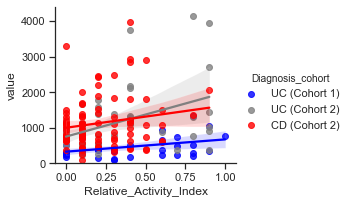

In [185]:
sns.set_style('white')
ax1 = sns.lmplot(x='Relative_Activity_Index', y = 'value', hue='Diagnosis_cohort',
                 palette=['blue','gray','red'],ci=95,data = dipep_melt,
                 truncate=True,height=3,aspect=1.25).set(ylim=(0, 4400))
plt.tick_params(left=True,bottom=True)
#plt.savefig('./Dipeptide_ScatterbyActivityMeanRACombinedDatasets_Normalized_final.pdf', bbox_inches='tight')

In [117]:
dipep_health = amino_melt[amino_melt['Diagnosis_cohort']=='Healthy_control (Cohort 2)']

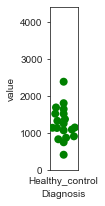

In [126]:
fig = plt.subplots(figsize=(0.5,3))
plot1 = sns.swarmplot(x='Diagnosis',y='value', palette=['green'],size=8, data=dipep_health)
plot1.set_ylim(0,4400)
plt.tick_params(left=True,bottom=False)
plt.savefig('Healthy_meanRAdipeptide_swarm_Normalized_Final.pdf',bbox_inches="tight")

In [66]:
#Stats on dipeptide average abundance and disease activity in IBD:
model = smf.ols(formula='value ~ Relative_Activity_Index + Diagnosis_cohort + Relative_Activity_Index:Diagnosis_cohort', data=dipep_melt).fit()
summary = model.summary()
summary.tables[0]

Dep. Variable:,value,R-squared:,0.227
Model:,OLS,Adj. R-squared:,0.206
Method:,Least Squares,F-statistic:,10.76
Date:,"Mon, 09 Nov 2020",Prob (F-statistic):,4.44e-09
Time:,10:32:52,Log-Likelihood:,-1493.1
No. Observations:,189,AIC:,2998.
Df Residuals:,183,BIC:,3018.
Df Model:,5,,
Covariance Type:,nonrobust,,


##### Identify the classes of metabolites commonly correlated to UC activity

In [143]:
#Perform linear regression on each metabolite from the Qemistree annotated molecules
#Load data
#Cohort 2
df = pd.read_csv('./Metabolomics/MB_Standardized_Table_Normalized_Final.txt', sep = '\t', index_col = '#OTU ID')
MB_meta = pd.read_csv('./Metabolomics/Qemistree_IDs.txt', index_col='rowid', sep='\t')
meta = pd.read_csv('./Combined_Metadata_Allomics_MB_V2.txt',sep='\t',index_col='#SampleID')

#UC Cohort 1
df2 =  pd.read_csv('../UC_Severity/Metabolomics/StandardizedMzMIne2020Rerun/UC40_MB_Table_normalized.txt',
                sep='\t',index_col='#OTU ID')
MB_meta2 = pd.read_csv('../UC_Severity/Metabolomics/StandardizedMzMIne2020Rerun/UC40_MB_Annotations.txt', index_col='rowID', sep='\t')
meta2 = pd.read_csv('../UC_Severity/UC_MP_Emperor_Map.txt',sep='\t',index_col = 'id')


In [132]:
#Create patient lists
UC_patients=list(set(meta[meta['Diagnosis']=='UC'].index)&set(df.columns))
Healthy = list(set(meta[meta['Diagnosis']=='Healthy_control'].index)&set(df.columns))
CD_patients=list(set(meta[meta['Diagnosis']=='CD'].index)&set(meta[meta['Relative_Activity_Index'] != 'Missing'].index)&set(df.columns))

In [133]:
#Subset out UC patients
UC = df[UC_patients]

In [134]:
LinearRegressions(df=UC,metadata=meta,variable='partial_Mayo')

'Linear regressions performed on partial_Mayo. New dataframe stored as "df_out"'

In [135]:
#Annotate the molecules
UC_ann = df_out.merge(MB_meta,left_index=True,right_index=True)

In [145]:
LinearRegressions(df=df2,metadata=meta2,variable='partial_Mayo')



'Linear regressions performed on partial_Mayo. New dataframe stored as "df_out"'

In [146]:
#Annotate the molecules from the first study
UC40_ann = df_out.merge(MB_meta2,left_index=True,right_index=True)

In [147]:
#Pull out top correlations
UC_sig = UC_ann[UC_ann['rvalue'] > 0.3]
UC40_sig = UC40_ann[UC40_ann['rvalue'] > 0.3]

#Remove unclassified
UC_sig = UC_sig[UC_sig['direct_parent'] != 'unclassified']
UC40_sig = UC40_sig[UC40_sig['direct_parent'] != 'unclassified']

#Generate a dataframe from the counts of each category
from collections import Counter
counts = Counter(UC_sig['direct_parent'])
countsdf = pd.DataFrame.from_dict(counts, orient = 'index')
countsdf = countsdf.rename(index = str, columns={0:"Number of Observations (Cohort 2)"})

counts = Counter(UC40_sig['direct_parent'])
countsdf2 = pd.DataFrame.from_dict(counts, orient = 'index')
countsdf2 = countsdf2.rename(index = str, columns={0:"Number of Observations (Cohort 1)"})

#merge the two count dataframes
counts = countsdf2.merge(countsdf,left_index=True,right_index=True,how='outer')

#Create a sum per class
counts['sum'] = counts.sum(axis=1)

#Save as a supplemental table
#counts.to_csv('./Supplemental_table_classified_sig_metabolites_normalized.csv')

In [152]:
#Percentage of dipeptides correlated to severity from total significant annotated molecules
counts.loc['Dipeptides']['sum']/counts['sum'].sum()

0.4492753623188406

In [153]:
#Percentage of Oligopeptides correlated to severity from total significant annotated molecules
counts.loc['Oligopeptides']['sum']/counts['sum'].sum()

0.057971014492753624

In [158]:
#Top classes associated with UC Severity
counts.sort_values(by='sum',ascending=False).iloc[0:2]

,Number of Observations (Cohort 1),Number of Observations (Cohort 2),sum
Dipeptides,6.0,25.0,31.0
Oligopeptides,4.0,NaN,4.0


##### Identifying the relationship between peptide fragments and IBD activity

In [69]:
#Load in dataframes:
df = pd.read_csv('./denovo_peptides_UC40_output.csv')
df2 = pd.read_csv('./de_novo_peptides_Run2.csv')

#Metadata:
meta = pd.read_csv('../UC_Severity/UC_MP_Emperor_Map.txt', sep = '\t')
meta2 = pd.read_csv('./Combined_Metadata_Allomics_MB_V1.txt', sep = '\t')

In [70]:
#List of Bacteroides protease producer categories:
High_overpros = ['H19','L18','H9','59','H5','77', 'H2','H7']
Med_overpros = ['57','H4','193','25']
Low_overpros = ['H10','137','12','H11']
Low_underpros = ['129','8','154']
Med_underpros = ['102','60','138','L7','179','60','L10','132']
High_underpros = ['200','L11','L19','L1','H15','L4','H20']

In [108]:
#Subset out low confidence peptides
df = df[df['ALC (%)'] > 85]
df2 = df2[df2['ALC (%)'] > 85]

#Count the number of high confidence peptides
from collections import Counter
counts = Counter(df['Source File'])
countsdf = pd.DataFrame.from_dict(counts, orient = 'index')

counts2 = Counter(df2['Source File'])
countsdf2 = pd.DataFrame.from_dict(counts2, orient = 'index')

#Rename the column
countsdf.rename(index = str, columns={0:"Number of Peptide Fragments"}, inplace = True)
countsdf2.rename(index = str, columns={0:"Number of Peptide Fragments"}, inplace = True)

#Replace FIT147 with proper vial number (entry error there was no FIT147)
countsdf.rename(index={'FIT147E3CAL':'FIT157E3CAL'},inplace=True)

#Create lists of filenames
filenames = list(meta['vial_name'])
filenames2 = list(meta2['id'].drop_duplicates())

#Create lists of samples with no peptides found
Identified_list = list(countsdf.index)
Identified_list2 = list(countsdf2.index)

#Find samples with no peptides found
nopeplist = list(set(filenames) - set(Identified_list))
nopeplist2 = list(set(filenames2) - set(Identified_list2))

#Create dataframes for these no peptide samples for merging
nopeplist_df = pd.DataFrame({'filename':nopeplist, 'Number of Peptide Fragments':0})
nopeplist_df2 = pd.DataFrame({'filename':nopeplist2, 'Number of Peptide Fragments':0})

#Align indexes
nopeplist_df.index = nopeplist_df['filename']
nopeplist_df2.index = nopeplist_df2['filename']

#Concatenate files
countsdf_merge = pd.concat([countsdf,nopeplist_df])
countsdf_merge = countsdf_merge.drop(labels='filename',axis=1)
countsdf_merge2 = pd.concat([countsdf2,nopeplist_df2])
countsdf_merge2 = countsdf_merge2.drop(labels='filename',axis=1)

#Make column for Proteome_ID to align with proteomic IDs used to identify overproducers.
meta['Proteome_ID']=meta['id']

#Merge on metadata
df_merge = countsdf_merge.merge(meta, left_index=True, right_on='vial_name')
df2_merge = countsdf_merge2.merge(meta2, left_index=True, right_on='id')

#Add an experiment column to the cohorts
df_merge['Experiment'] = 'UC (Cohort 1)'
df2_merge['Experiment'] = 'UC (Cohort 2)'

#Add a UC diagnosis to first cohort
df_merge['Diagnosis'] = 'UC'

#Combine the dataframes
combined_df = pd.concat([df2_merge,df_merge])

#Remove the indeterminate diagnosis patient
combined_df = combined_df[combined_df['Diagnosis'] == 'UC']



In [109]:

Protease_cat = []
for i in combined_df['Proteome_ID']:
    if i in High_overpros:
        Protease_cat.append('Overproducer')
    elif i in Med_overpros:
        Protease_cat.append('Overproducer')
    elif i in Low_overpros:
        Protease_cat.append('Overproducer')    
    elif i in Med_underpros:
        Protease_cat.append('Underproducer')
    elif i in Low_underpros:
        Protease_cat.append('Others')
    elif i in High_underpros:
        Protease_cat.append('Underproducer')    
    else:
        Protease_cat.append('Others')

combined_df['Bv Protease Producer Category'] = Protease_cat



[Text(0, 0, 'Healthy_control')]

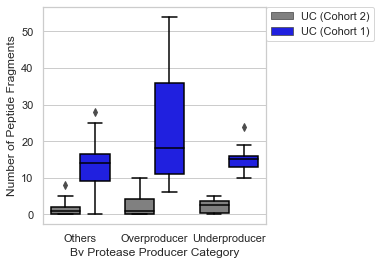

In [110]:
sns.set(rc={'figure.figsize':(4,4)})
sns.set_style("whitegrid")
ax = sns.boxplot(x='Bv Protease Producer Category', 
                 y='Number of Peptide Fragments',hue='Experiment',
                 palette=['gray','blue'],data=combined_df)
# iterate over boxes
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    #box.set_facecolor('white')

    # iterate over whiskers and median lines
    for j in range(6*i,6*(i+1)):
         ax.lines[j].set_color('black')

plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plot1.set_xticklabels(plot1.get_xticklabels(),rotation=90)
#plt.savefig('Bv_protease_outliers_pepfragmentsanalysis_boxplots_ExperimentSeparated.pdf', bbox_inches="tight")


There was a clear difference in the number of peptides identified in cohort 1 and cohort 2 that has an unknown technical and not biological reason. Therefore, the peptide fragments analyses were primarily performed on UC Cohort 1

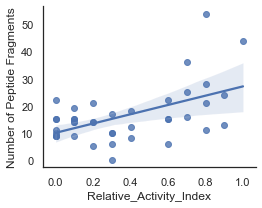

In [147]:
#Subset to UC Cohort 1
UC1 = combined_df[combined_df['Experiment']=='UC (Cohort 1)']
UC1['Relative_Activity_Index']=UC1['Relative_Activity_Index'].astype(float)

ax1 = sns.lmplot(x='Relative_Activity_Index', y = 'Number of Peptide Fragments',ci=95,data = UC1,
                 palette=['blue'],truncate=True,height=3,aspect=1.25)#.set(ylim=(0, 100000))
#plt.savefig('./UC40_Peptide_Activity_Scatter95CI.pdf', bbox_inches='tight')

##### Identifying protease activity type in the proteome of Bacteroides supernatant

First create a datatable from raw peptide spectral match data

In [127]:
##Normalize raw data

#Read data tables
Labels = pd.read_csv('./Bacteroides_supernatant/BSuper_LabelLayout.csv',dtype='str')
df = pd.read_csv('./Bacteroides_supernatant/Raw_data_psmsonly.txt',sep='\t')

#Removing characters from beginning and end of the spectrum files to make a columns consistent
#for each experiment
Exp_list = []
for i in df.index:
    if len(df.loc[i]['Spectrum File']) == 21:
        a = df.loc[i]['Spectrum File'][9:-6]
        Exp_list.append(a)
    else:
        a = df.loc[i]['Spectrum File'][9:-7]
        Exp_list.append(a)

#Add the adjusted spectrum files to a new column
df['Experiment'] = Exp_list

Labels.index = Labels['Experiment']

#Perform quality filtering
PSM_quality_filters(df, Labels)

Number of low confidence PSMs removed: 0
Number of ambiguous 'rejected' PSMs removed: 81
Number of PSMs with high interference removed: 7378
Number of redundant PSMs removed: 306
Number of PSMs with low average signal removed: 13351
Percent of PSMs removed during quality filtering: 0.6159141290397854
Dataframes per experiment with low quality PSMs removed saved under name: dataframe_collection


In [128]:
#Sum PSM to protein quant values
Sum_PSMs_per_Experiment(df_collection=dataframe_collection, labels_df=Labels, experiment_column='Experiment')

Number of proteins quantified in Experiment BSuper: 2574
Collection of dataframes per experiments saved under name: dataframe_collection2; Median of protein averages saved under name: Avg_median


In [ ]:
#Save the dataframe
#dataframe_collection2['BSuper'].to_csv('./Bacteroides_supernatant/Nonnormalized_protein_values.csv')

In [132]:
df = pd.read_csv('./Bacteroides_supernatant/Nonnormalized_protein_values.csv')
ann = pd.read_csv('./Bacteroides_supernatant/Uniprot_annotations_categorized.txt', sep = '\t')

#TIC normalize the raw abundances
channels = ['126','130N','128N','129N','130C','127N','128C','129C','127C']
for i in channels:
    sumi=df[i].sum()
    df[i] = (df[i]/sumi)*100000
    
df.index = df['Protein']
df = df[channels]

#Add annotations to the dataframe
df=df.merge(ann, left_index=True,right_on='Entry')

Analyze proteins from the supernatants

In [136]:
meta = pd.DataFrame({'Sample_Name': [ 'BV1', 'BT3', 'BD3', 'BV3', 'BD1', 'BT1', 'BD2', 'BV2', 'BT2'],
                   'TMT_Channel': channels,
                    'Species': [ 'B. vulgatus', 'B. theta', 'B. dorei', 'B. vulgatus', 'B. dorei', 'B. theta', 'B. dorei', 'B. vulgatus', 'B. theta']})
meta.index = meta['TMT_Channel']

In [139]:
df2 = df

#Create dataframes of proteins when containing enzymes or peptidases/proteases
Enzymes = df2[df2['KEGG_Functional_Category']=='Enzyme Families']
Pept = df2[df2['Protein names'].str.contains('peptidase|protease',case=False)==True]
ProteDf = pd.concat([Enzymes,Pept])

#Drop if duplicated
ProteDf = ProteDf.drop_duplicates()

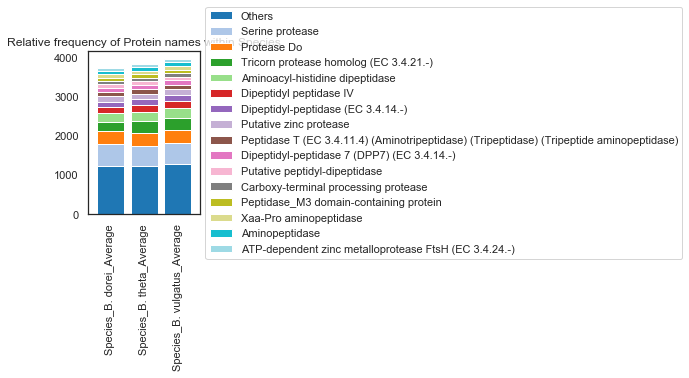

In [148]:
#Not in manuscript, but this plots the most abundant proteases in supernatants.
PlotByCategory(df=ProteDf,samples=channels,Taxa_col='Protein names',category='Species',metadata=meta,display_number=15,
               save_descrip='BacteroidesSupernatantEnzymesorPeptidasesComposition_15_TIC_notrelative_submission',relative="False")


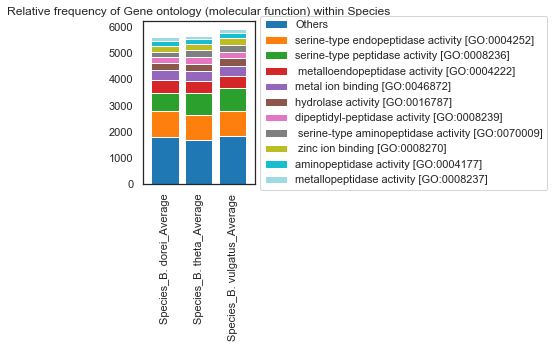

In [149]:
PlotByCategory(df=ProteDf,samples=channels,Taxa_col='Gene ontology (molecular function)',category='Species',metadata=meta,display_number=10,
               save_descrip='BacteroidesSupernatantEnzymesorPeptidasesorProteases_GOComposition_10_TIC_Notrelative_Final',relative="False")

##### Identifying proteases increased in B. vulgatus or B. dorei supernatant

In [151]:
#Sum by protein name
Prot_sums = ProteDf[channels].groupby([ProteDf['Protein names']]).sum()

#Name the channels from each species
BV = ['126','130N','128N']
BT = ['129N','130C','127N']
BD = ['128C','129C','127C']

#Sum technical triplicates
Prot_sums['BV_Sum'] = Prot_sums[BV].sum(axis=1)
Prot_sums['BT_Sum'] = Prot_sums[BT].sum(axis=1)
Prot_sums['BD_Sum'] = Prot_sums[BD].sum(axis=1)

#Divide the sum of each protein by the B theta (control) sum
Prot_sums['BV_div_BT'] = Prot_sums['BV_Sum']/Prot_sums['BT_Sum']
Prot_sums['BD_div_BT'] = Prot_sums['BD_Sum']/Prot_sums['BT_Sum']
Prot_sums['Log_BV_div_BT'] = np.log10(Prot_sums['BV_div_BT'])
Prot_sums['Log_BD_div_BT'] = np.log10(Prot_sums['BD_div_BT'])

Prot_sums=Prot_sums.sort_values('BV_div_BT',ascending=False)

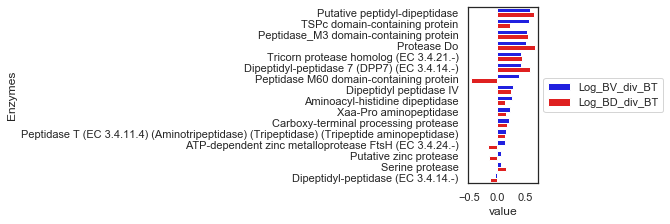

In [162]:
#Make another column for the protein names when performing the melt function
Prot_sums['Enzymes'] = Prot_sums.index

#Subset out only the most abundant proteases in B. vulgatus
Enzyme_sums2=Prot_sums[Prot_sums['BV_Sum']>300]

#If running into many proteins at this point you can also filter down to only the top hits
Enzyme_sums2=Enzyme_sums2.sort_values('BV_div_BT', ascending=False)[0:16]

AllEnzymeMelt2=pd.melt(Enzyme_sums2,value_vars=('Log_BV_div_BT','Log_BD_div_BT'),id_vars='Enzymes')

#Make plot
fig = plt.subplots(figsize=(1.25,3.25))
plot1 = sns.barplot(x = 'value', y = 'Enzymes', hue = 'variable',palette=['blue','red'], data = AllEnzymeMelt2)    
plot1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plot1
plt.savefig('./Bacteroides_supernatant/BV_EnrichmentofAbundantProteins_top16_TIC.pdf',bbox_inches="tight")

##### Identifying overlap between proteases identified in patients and different species supernatant

In [163]:
##LOAD DATA

#Proteases from UC Patients
df1 = pd.read_csv('./pMayo_correlations_MP_MGDB_annotated.csv', index_col = 'Master Protein')
df2 = pd.read_csv('./pMayo_correlations_MP_MGDB_annotated_UC40.csv', index_col=0)

#Proteases identified in supernatant
df_bs = pd.read_csv('./Bacteroides_supernatant/Supernatant_protease_identifications.csv')

#Proteases confirmed to be transfered in UC Fecal transplantation
df_f = pd.read_csv('./Bvulgatus_proteases_H19vL3_piscores.csv')

In [164]:
#Subset out only top correlations to UC activity
df2 = df2[df2['rvalue'] > 0.3]
df1 = df1[df1['rvalue'] > 0.3]

#Subset out only proteins from species of interest
species_interest = ['Bacteroides dorei', 'Bacteroides vulgatus']
df2 = df2[df2['Species'].isin(species_interest)]
df1 = df1[df1['Species'].isin(species_interest)]

#Subset out enzymes or proteases
df1_enz = df1[df1['KEGG_Functional_Category'] == 'Enzyme Families'] 
df1_pept = df1[df1['Protein names'].str.contains('peptidase|protease',case=False)==True]
df1_all = pd.concat([df1_pept,df1_enz])
IBD200 = set(df1_all['Protein names'])

df2_enz = df2[df2['KEGG_Functional_Category'] == 'Enzyme Families'] 
df2_pept = df2[df2['Protein names'].str.contains('peptidase|protease',case=False)==True]
df2_all = pd.concat([df2_pept,df2_enz])
UC40 = set(df2_all['Protein names'])

In [174]:
#Make lists of proteins that are significant or of interest
Overlap_proteins = list(UC40 & IBD200)
Sup_pres = set(list(df_bs['B. vulgatus'])+list(df_bs['B. dorei']))
Sup_BVBTunique = set(df_bs['BV + BD - BT'])
Sig_inpatients=set(list(UC40)+list(IBD200))
BT =set(df_bs['B. theta'])

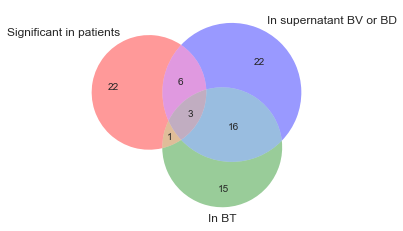

In [175]:
venn = venn3(subsets=(Sig_inpatients,Sup_pres,BT),set_labels=('Significant in patients','In supernatant BV or BD','In BT'),set_colors=('red','blue','green'))
#plt.savefig('./BVorBDproteases_PatientsSupernatantsBT_comparison_venn.pdf')

##### Shape analysis from Caco-2 with B. vulgatus in vitro studies

In [176]:
#LOAD DATA
df = pd.read_csv('../UC_Severity/In_vitro/Imaging_shape_data.txt',sep='\t')

#Melt to longform
value_vars=['Circ','AR','Round','Solidity']
ids=['Image','Cell_number']
df_melt=pd.melt(df,value_vars=value_vars,id_vars=ids)

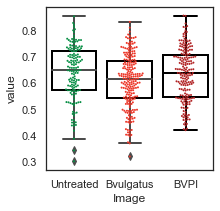

In [182]:
#Make plot
sns.set(rc={'figure.figsize':(3,3)})
sns.set_style("white")
cmap=sns.color_palette(palette=['#088F45','#ED3527','#B22425'])
df_melt2=df_melt[df_melt['variable']=='Circ']
plot = sns.swarmplot(x='Image', y='value',data=df_melt2,size=2,palette=cmap)
plot1=sns.boxplot(x='Image', y='value', linewidth=2, data=df_melt2)
swarm1=plot.artists[1]
swarm1.set_color='red'

#plot1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# iterate over boxes
for i,box in enumerate(plot1.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

    # iterate over whiskers and median lines
for j in range(6*i,6*(i+1)):
    plot1.lines[j].set_color('black')
plt.savefig('./Imaging_Circularity_plotted.pdf', bbox_inches="tight")

In [180]:
#Make lists of values for significance test
a =list(df_melt2[df_melt2['Image']=='Untreated']['value'])
b =list(df_melt2[df_melt2['Image']=='Bvulgatus']['value'])
c =list(df_melt2[df_melt2['Image']=='BVPI']['value'])

In [181]:
#Find p-value between Bvulgatus and Bvulgatus + Protease inhibitor cocktail
scipy.stats.ttest_ind(a=b,b=c)

Ttest_indResult(statistic=-2.440716473982313, pvalue=0.01507340500153093)

##### Process and normalize data from fecal transplant metaproteome study 

In [188]:
##LOAD DATA
Labels = pd.read_csv('./UC_Fecal_Transplant_MP/UCT_LabelLayout.csv', dtype='str')
df = pd.read_csv('./UC_Fecal_Transplant_MP/Raw_PSMs.txt', sep = '\t')

Labels.index = Labels['Experiment']

In [189]:
#Removing characters from beginning and end of the spectrum files to make a columns consistent
#for each experiment
Exp_list = []
for i in df.index:
    if len(df.loc[i]['Spectrum File']) == 20:
        a = df.loc[i]['Spectrum File'][9:-7]
        Exp_list.append(a)
    else:
        a = df.loc[i]['Spectrum File'][9:-6]
        Exp_list.append(a)

In [190]:
#Add the adjusted spectrum files to a new column
df['Experiment'] = Exp_list

#Perform quality filtering
PSM_quality_filters(df, Labels)

Number of low confidence PSMs removed: 0
Number of ambiguous 'rejected' PSMs removed: 651
Number of PSMs with high interference removed: 21831
Number of redundant PSMs removed: 3636
Number of PSMs with low average signal removed: 34767
Percent of PSMs removed during quality filtering: 0.5681690929451287
Dataframes per experiment with low quality PSMs removed saved under name: dataframe_collection


In [193]:
bridge_channels=['126','131']
Sum_PSMs_per_Experiment_bridge(df_collection=dataframe_collection, labels_df=Labels, experiment_column='Experiment', bridge_channels=bridge_channels)

Number of proteins quantified in Experiment UCT1: 7703
Number of proteins quantified in Experiment UCT2: 8533
Collection of dataframes per experiments saved under name: dataframe_collection2; Median of bridge channel saved under name: bridge_median


In [194]:
Two_Bridge_Normalization(df_collection=dataframe_collection2, label_df=Labels, bridge_median=bridge_median, bridge_channels=bridge_channels)

Dataframe with normalized protein quants saved under name: Normalized_df


In [ ]:
#SAVE NORMALIZED DATA

#Normalized_df.to_csv('./UC_Fecal_Transplant_MP/Normalized_proteins.csv')

##### Identify proteases in the stool of mice from fecal microbiota transplant study

In [62]:
df = pd.read_csv('./UC_Fecal_Transplant_MP/Normalized_proteins.csv',index_col='Master Protein')
protein_meta = pd.read_csv('./UC_Fecal_Transplant_MP/All_annotations_categorized.txt',sep='\t')
meta = pd.read_csv('./UC_Fecal_Transplant_MP/UCT_metadata.csv')

In [63]:
#List of sample names
ids=['LP2','LP3','LPI1','LPI2','LPI3','HP1','HP2','HP3','HPI1','HPI2','HPI3']

#Merge data with protein metadata
df2 = df.merge(protein_meta,left_index=True,right_on='queryID')

#Update to relevant index
meta.index = meta['sample_name']

In [64]:
##UPDATE FUNCTION TO HAVE DIMENSIONS IN MANUSCRIPT
def PlotByCategory(df,samples,Taxa_col,category,metadata,display_number,save_descrip,human="True",relative=True):
    """
    This function allows you to average the abundance of a category by the levels within that category
    and plot stacked barplots of the relative abundance of the x most abundant groups within 
    each level
    
    Parameters
    ----------
    df_sig : pd.DataFrame
    Taxa_col : String; Name of variable to plot
    category : String; Name of variable to average by
    display_number: np.integer; Number of variables to plot
    relative : True/False
    human: String
    save_descrip : String

    Returns
    -------
    Dataframe with comparative ratios
    Dataframe with counts
    """
    #Sum your dataframe by a category of interest 
    dfcategories = df[samples].groupby(df['%s' % Taxa_col]).agg(['sum'])
    #Restructure the columns which become multilevel with the sum function                  
    dfcategories.columns = dfcategories.columns.droplevel(1)

    if human != "True":
        dfcategories.drop('Homo sapiens (Human)', inplace=True)
        
    
    #Save the postive and negative correlations per genera or eggNOG category
    counts = dfcategories
    
    #Find averages according to the levels in a category of interest
    
    #subset metadata to only list with patients of interest
    metadata.index = metadata.index.astype('str')
    meta2 = metadata.loc[samples]
    #Identify the levels within the metadata category
    levels_list = list(meta2[category].drop_duplicates().sort_values())
    #Add new column for patients regarding the level of the category of interest.
    counts.loc['%s' % category] = metadata['%s' % category]

    #Create a new column averaging by the levels within the category
    col_list = []
    for i in levels_list:
        a = counts[samples].T
        patients_in = []
        patients_in = list(a[a[category] == i].index.astype('str'))
        b = counts[patients_in].drop(category)
        b = b.astype('float')
        counts['%s_%s_Average' % (category, i)] = b[patients_in].mean(axis=1)
        col_list.append('%s_%s_Average' % (category, i))
    
    plot_df = counts[col_list]

    #Find the sum per variable
    plot_df['sum'] = plot_df.sum(axis=1)
    
    #Find the most abundantly correlated entry within the variable, group others
    top_list = list(plot_df.sort_values('sum', ascending=False)[0:display_number].index)
    Others = set(plot_df.index) - set(top_list)
    plot_df.loc['Other Species'] = plot_df.loc[Others].sum()
    top_list.append('Other Species')

    plot_df = plot_df.loc[top_list]

    #Convert to ratio for display
    if relative==True:
        for i in col_list:
            plot_df[i] = plot_df[i]/plot_df[i].sum()
            plot_df = plot_df[col_list]
    else:
        plot_df = plot_df[col_list]
        
    
    
    #Remove index name
    del plot_df.index.name
    #Transpose
    plot_df = plot_df.transpose()
    #Get the dates in the correct order
    plot_df = plot_df.reindex(col_list)
    #Get variable into an order which depends on the abundance of each variable for easier interpretation
    plot_df = plot_df[plot_df.sum().sort_values(ascending = False).index]
    
    vals = np.linspace(0,1,display_number)
    np.random.shuffle(vals)
    my_cmap = plt.cm.colors.ListedColormap(plt.cm.Dark2(vals))
    
    plot1 = plot_df.plot(kind='bar', width = 0.8, stacked=True, colormap='tab20', figsize=(3,2),title='Relative frequency of %s within %s' % (Taxa_col,category))
    plot1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plot1
    plt.savefig('./UC_Fecal_Transplant_MP/Barplot_of_%s_by_%s_%s.pdf' %(Taxa_col,category,save_descrip),bbox_inches="tight")
    

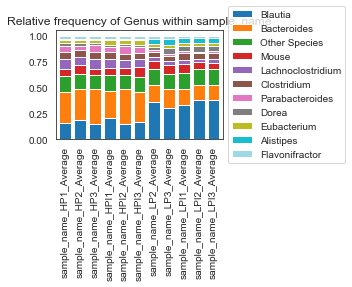

In [65]:
#Plot the genera composition in the metaproteome of the different samples
PlotByCategory(df=df2,samples=ids,Taxa_col='Genus',category='sample_name',metadata=meta,
               display_number=10,save_descrip='MP_Genera_Composition_Final')

In [17]:
#Filter out to grab all proteases and enzymes
Enzymes = df2[df2['KEGG_Functional_Category']=='Enzyme Families']
Pept = df2[df2['Protein names'].str.contains('peptidase|protease',case=False)==True]
ProteDf = pd.concat([Enzymes,Pept])
#Drop if duplicated
ProteDf = ProteDf.drop_duplicates()

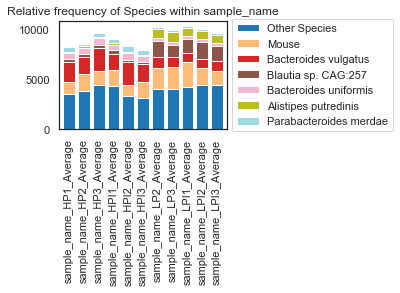

In [202]:
#Identify the source of the enzymes and proteases in the different samples
PlotByCategory(df=ProteDf,samples=ids,Taxa_col='Species',category='sample_name',metadata=meta,display_number=6,
               save_descrip='All_ProteasesandEnzyme_notrelative6_final',relative=False)

Identify the molecular class of Bacteroides vulgatus proteases:

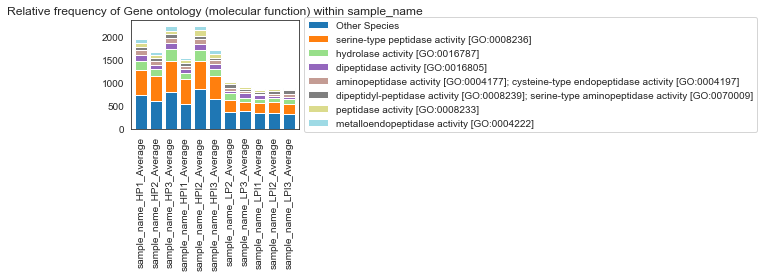

In [26]:
BvProtDf=ProteDf[ProteDf['Species']=='Bacteroides vulgatus']
PlotByCategory(df=BvProtDf,samples=ids,Taxa_col='Gene ontology (molecular function)',category='sample_name',metadata=meta,display_number=7,
               save_descrip='BV_ProteasesandEnzyme_MolFunc_notrelative7_final',relative=False)

##### Identify proteins increased in high Bacteroides proteases fecal transplant fecal samples

In [27]:
#HP vs LP lists
H19 = list(meta[meta['Donor_ID'] == 'H19'].index)
L3 = list(meta[meta['Donor_ID'] == 'L3'].index)

#Subset dfs
H19_df = df[df.columns[df.columns.isin(H19)]]
L3_df = df[df.columns[df.columns.isin(L3)]]

#Perform t-tests
TwoCategoryMaster(df, H19_df, L3_df, 'H19', 'L3')

Fold Change Column Name = 'Fold Change(H19/L3)'


In [48]:
#Annotate proteins
df2=df.merge(protein_meta,left_index=True,right_on='queryID')
#OPTION TO SAVE
#df2.to_csv('./UC_Fecal_Transplant_MP/All_Piscores.csv')

#Filter out to grab all proteases and enzymes
Enzymes = df2[df2['KEGG_Functional_Category']=='Enzyme Families']
Pept = df2[df2['Protein names'].str.contains('peptidase|protease',case=False)==True]
ProteDf = pd.concat([Enzymes,Pept])
#Drop if duplicated
ProteDf = ProteDf.drop_duplicates()

#Subset only Bacteroides vulgatus
BvProtDf=ProteDf[ProteDf['Species']=='Bacteroides vulgatus']

#Sort and subset to top 10
BvProtDf2=BvProtDf.sort_values('H19/L3 pi score',ascending=False)[0:17]

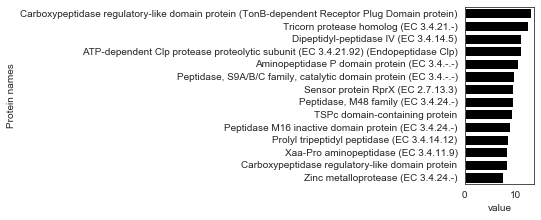

In [55]:
#Melt to longform
BvProtMelt=pd.melt(BvProtDf2,value_vars='H19/L3 pi score',id_vars='Protein names')
BvProtMelt=BvProtMelt.drop_duplicates('Protein names')
#Plot the most significant proteases from B vulgatus fecal transplants
fig = plt.subplots(figsize=(1.25,3.25))
plot1 = sns.barplot(x = 'value', y = 'Protein names',palette=['black'], data = BvProtMelt)
plot1
plt.savefig('./TopBVProteasesInH19_Bars_Final.pdf',bbox_inches="tight")

##### Find the overlap between all Bacteroides vulgatus or Bacteroides dorei proteases in the various proteomic studies of this project

In [58]:
#Subset out only the proteins from B. vulgatus or B. dorei
bd = df2[df2['Species'] == 'Bacteroides dorei']
bv = df2[df2['Species'] == 'Bacteroides vulgatus']
#Combine the dataframes
df3 =pd.concat([bv,bd])

#Find the proteases and enzymes from Bv and Bd
Enzymes = df3[df3['KEGG_Functional_Category']=='Enzyme Families']
Pept = df3[df3['Protein names'].str.contains('peptidase|protease',case=False)==True]
ProteDf_bv = pd.concat([Enzymes,Pept])
#Drop if duplicated
ProteDf_bv = ProteDf_bv.drop_duplicates()

In [59]:
#Create lists of samples by the patient ids
H19 = list(meta[meta['Donor_ID'] == 'H19'].index)
L3 = list(meta[meta['Donor_ID'] == 'L3'].index)

#Subset out columns from the dataframe that were from patient H19 (High bacteroides vulgatus proteases) and L3 (Control/Low proteases)
H19_ProteDf_bv = ProteDf_bv[ProteDf_bv.columns[ProteDf_bv.columns.isin(H19)]]
L3_ProteDf_bv = ProteDf_bv[ProteDf_bv.columns[ProteDf_bv.columns.isin(L3)]]

#Perform binary comparisons
TwoCategoryMaster(ProteDf_bv, H19_ProteDf_bv, L3_ProteDf_bv, 'H19', 'L3')

#Option to save the dataframe
#ProteDf_bv.to_csv('./Bvulgatus_proteases_H19vL3_piscores.csv')

Fold Change Column Name = 'Fold Change(H19/L3)'


Plot the top proteins associated with high Bacteroides proteases samples

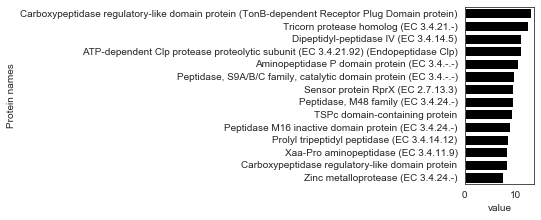

In [61]:
#Drop if duplicated
ProteDf = ProteDf_bv.drop_duplicates()


#Sort and subset to top associations
BvProtDf2=BvProtDf.sort_values('H19/L3 pi score',ascending=False)[0:17]

#Melt to longform
BvProtMelt=pd.melt(BvProtDf2,value_vars='H19/L3 pi score',id_vars='Protein names')
BvProtMelt=BvProtMelt.drop_duplicates('Protein names')
#Plot the most significant proteases from B vulgatus fecal transplants
fig = plt.subplots(figsize=(1.25,3.25))
plot1 = sns.barplot(x = 'value', y = 'Protein names',palette=['black'], data = BvProtMelt)
plot1
plt.savefig('./TopBVProteasesInH19_Bars_Final.pdf',bbox_inches="tight")

In [209]:
#Make an additional list of the proteases significantly increased in the protease overproducing transplant mice
df_f=ProteDf_bv
df_f=df_f[df_f['H19/L3 pi score']>1]
transplants = set(df_f['Protein names'])

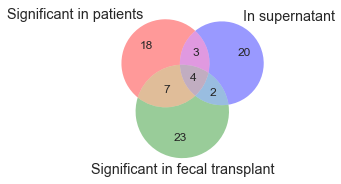

In [210]:
#Plot the overlap between the lists of protease names:
venn = venn3(subsets=(Sig_inpatients,Sup_BVBTunique,transplants),set_labels=('Significant in patients','In supernatant','Significant in fecal transplant'),set_colors=('red','blue','green'))
#plt.savefig('./BVorBDproteases_PatientsSupernatantsUnique_Transplants_comparison_venn.pdf')

In [211]:
#Save a table with protein names identified
Identified_Proteases = dict({'IBD200andUC40': Overlap_proteins,
                   'UC40': list(UC40),
                    'IBD200': list(IBD200),
                           'IBD200orUC40':list(Sig_inpatients),
                           'InBvorBdSupernatant':list(Sup_pres),
                           'SigInFecaltransplants':list(transplants)})
ID_df = pd.DataFrame.from_dict(Identified_Proteases,orient='index')
#ID_df.T.to_csv('./Significant_BvandBdprotease_identifications_transplantandsupernatantsalso.csv')